# Generate Bounding Boxes

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, convert_map_to_road_map

from bb_helper import coordinates_to_binary_tensor, batch_coordinates_to_binary_tensor
from bb_helper import binary_tensor_to_coordinates, batch_binary_tensor_to_coordinates

from PIL import Image
import cv2

import time
import copy

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '..\\..\\data'
annotation_csv = '../../data/annotation.csv'

In [4]:
transform = torchvision.transforms.ToTensor()

In [5]:
# unlabeled_scene_index = np.arange(106)
labeled_scene_index = np.arange(125, 134) # default (106, 134)

In [6]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=False # Can change to true and get extra info
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [7]:
sample, target, road_image, boxes = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


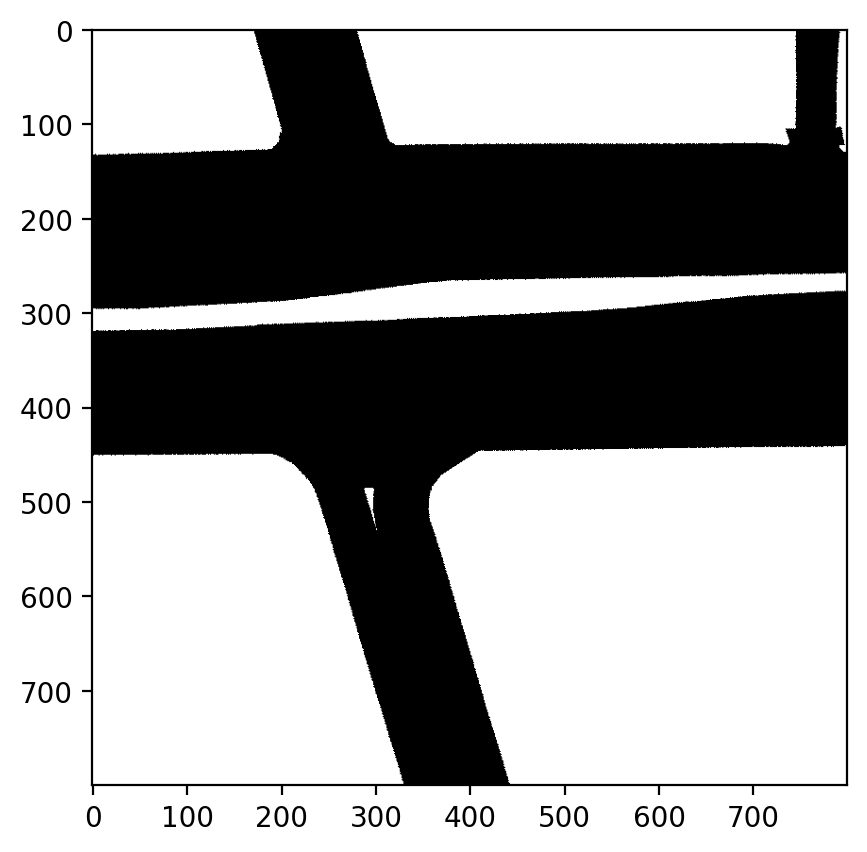

In [8]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()
ax.imshow(road_image[0], cmap='binary');

# Convert bounding box coordinates to binary map

In [9]:
boxes = list(boxes)
boxes[0].shape

torch.Size([14, 2, 4])

In [10]:
def draw_black_box(ax, corners):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color='black', linewidth=0.5)

In [11]:
def car_angle(bl, br):
    abs_angle = np.arccos((bl[1] - br[1]) / torch.norm(bl - br, 2)) * (180 / np.pi)
    if bl[0] <= br[0]:
        return -abs_angle
    else:
        return abs_angle

def draw_black_rectangle(ax, corners):
    fl, fr, bl, br = corners[:, 0], corners[:, 1], corners[:, 2], corners[:, 3]
    xy = (br[0] * 10 + 400, -br[1] * 10 + 400)
    width = torch.norm(br - fr, 2) * 10
    height = -torch.norm(br - bl, 2) * 10
    rect = mpatches.Rectangle(xy, width, height, angle=car_angle(bl, br), color='black')
    ax.add_patch(rect)

In [12]:
### Plot empty background (or negative roadmap) ###
fig, ax = plt.subplots()
plt.axis('off')
background = torch.zeros((800,800)) > 0
# background = ~road_image[0]
ax.imshow(background, cmap='binary');

### Draw Boxes ###
for i, bb in enumerate(boxes[0]):
    draw_black_rectangle(ax, bb)

### Ensure DPI is Correct and Save Image ###
DPI = 200
matplotlib.rcParams['figure.dpi'] = DPI
fig.set_size_inches(800.0/float(DPI),800.0/float(DPI))
fig.canvas.draw()
plt.close(fig)


In [13]:
# Now we can save it to a numpy array.
bb_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
bb_image = bb_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
bb_image_gray = cv2.cvtColor(bb_image,cv2.COLOR_BGR2GRAY)
bb_image_binary = torch.tensor(bb_image_gray) < 255
bb_image_binary.shape

torch.Size([800, 800])

In [14]:
# Test batch_coordinates_to_binary_tensor function
output_tensors_stacked = batch_coordinates_to_binary_tensor(boxes)
output_tensors_stacked.shape

torch.Size([2, 800, 800])

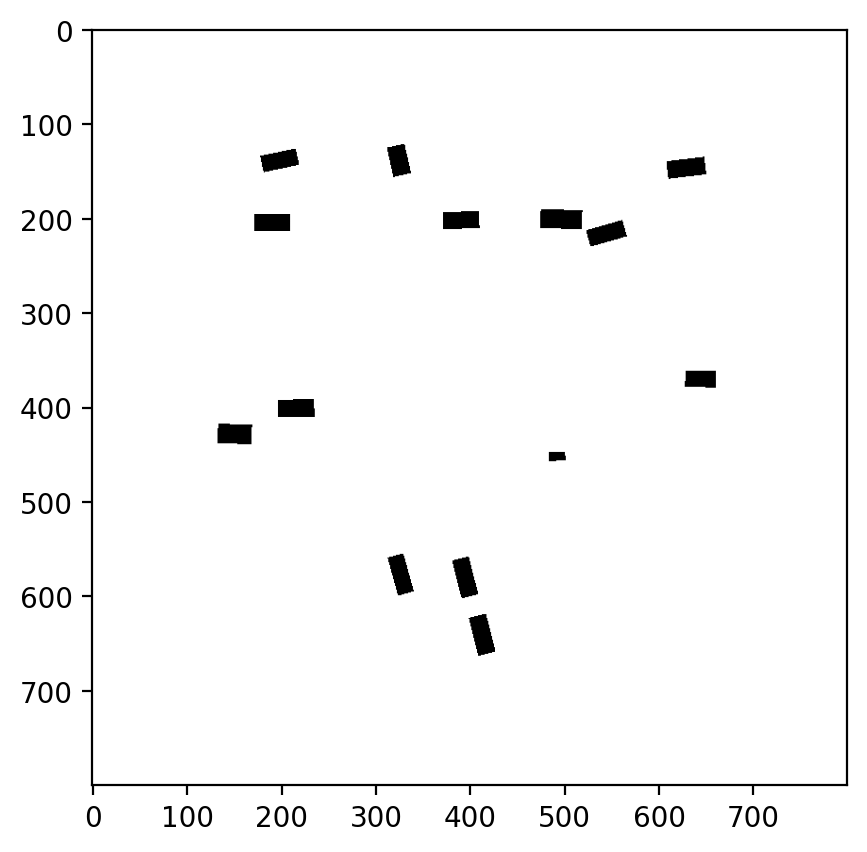

In [15]:
fig, ax = plt.subplots()
ax.imshow(output_tensors_stacked[0], cmap='binary');

# Convert binary map to bounding box coordinates

### Identify Edges

In [16]:
bb_binary = output_tensors_stacked[0]
bb_image_gray = np.array((bb_binary != True).int()*255).astype(np.uint8)

In [17]:
# Find Canny edges 
edged = cv2.Canny(bb_image_gray, 30, 200)
  
# Find Contours 
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(boxes[0]), len(contours))

14 14


### Identify Corners

In [18]:
coords_list = []
for c in contours:
    rect = cv2.minAreaRect(c)
    boxPoints = cv2.boxPoints(rect)
    if np.linalg.norm(boxPoints[0] - boxPoints[1]) < np.linalg.norm(boxPoints[0] - boxPoints[3]):
        coord_indices = (0, 1, 3, 2)
    else:
        coord_indices = (1, 2, 0, 3)
    fl_idx, fr_idx, bl_idx, br_idx = coord_indices
    boxPoints = np.array([boxPoints[fl_idx], boxPoints[fr_idx], boxPoints[bl_idx], boxPoints[br_idx]])
    corners = torch.tensor(boxPoints).T
    corners[0] = (corners[0] - 400) / 10
    corners[1] = - (corners[1] - 400) / 10
    coords_list.append(corners)
    
coords_output = torch.stack(coords_list)
coords_output.shape

torch.Size([14, 2, 4])

### Plot Final Coordinates

In [19]:
# Test batch_binary_tensor_to_coordinates
batch_coords_output = batch_binary_tensor_to_coordinates(output_tensors_stacked)
batch_coords_output[0].shape

torch.Size([14, 2, 4])

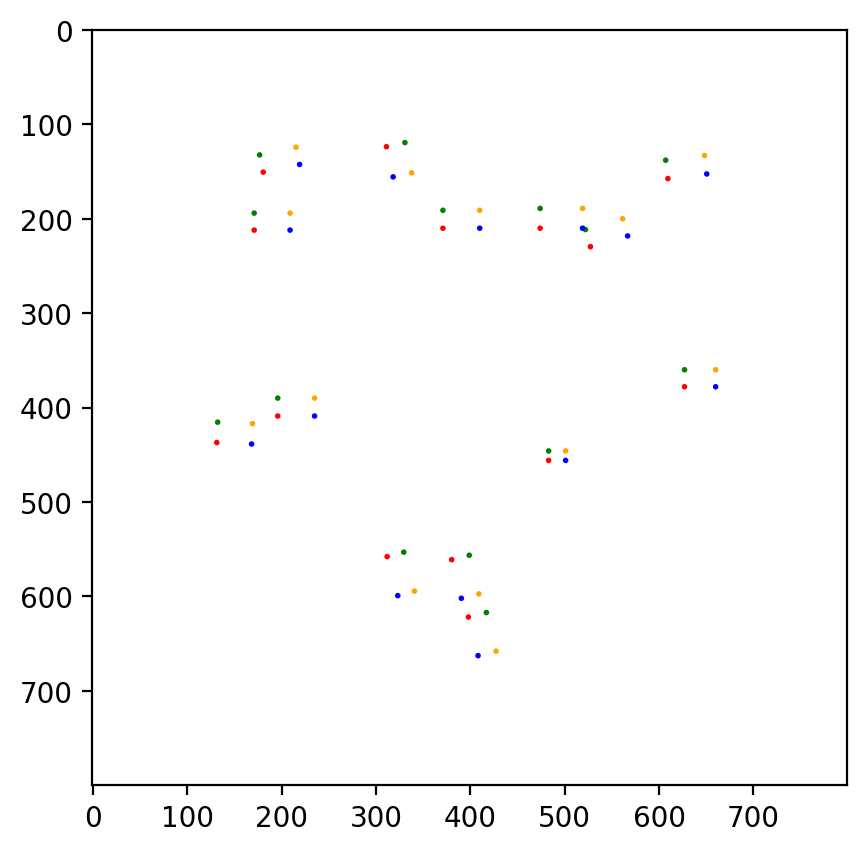

In [20]:
blank = torch.zeros((800,800)) > 0
# blank = road_image[0] != True

# # Intermediate contours from above; optional
# for contour in contours:
#     for point in contour.squeeze():
#         blank[point[1].item()][point[0].item()] = True
        
fig, ax = plt.subplots()
ax.imshow(blank, cmap='binary');
for coords in batch_coords_output[0]:
    coords[0] = (coords[0] * 10) + 400
    coords[1] = - (coords[1] * 10) + 400
    plt.scatter(coords[0], coords[1], color=['red', 'green', 'blue', 'orange'], s=1)

# Convert back and forth to stress-test

In [21]:
test_boxes = copy.deepcopy(boxes)

In [22]:
boxes[0][0]

tensor([[-12.6539, -10.6949, -11.8421,  -9.8831],
        [ 36.0531,  36.4936,  32.4422,  32.8827]], dtype=torch.float64)

In [23]:
test_tensors = batch_coordinates_to_binary_tensor(test_boxes)

In [24]:
test_boxes = batch_binary_tensor_to_coordinates(test_tensors)

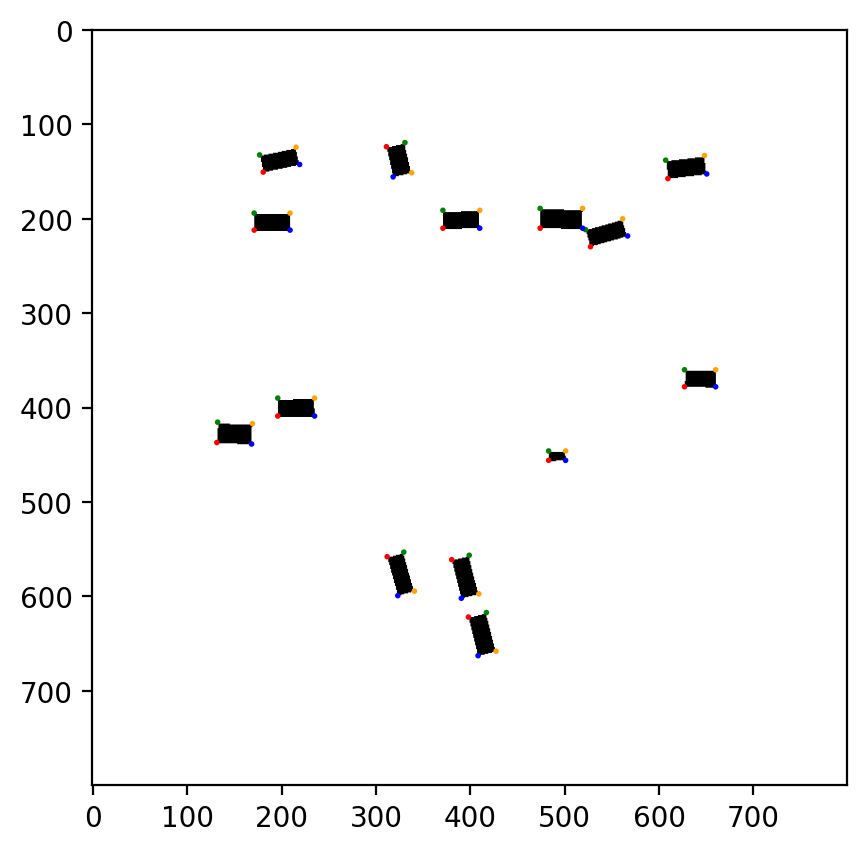

In [25]:
fig, ax = plt.subplots()
ax.imshow(test_tensors[0], cmap='binary');
for coords in test_boxes[0]:
    plt.scatter((coords[0] * 10) + 400, -(coords[1] * 10) + 400, color=['red', 'green', 'blue', 'orange'], s=1)

In [32]:
test_tensors = batch_coordinates_to_binary_tensor(test_boxes)

In [33]:
test_boxes = batch_binary_tensor_to_coordinates(test_tensors)

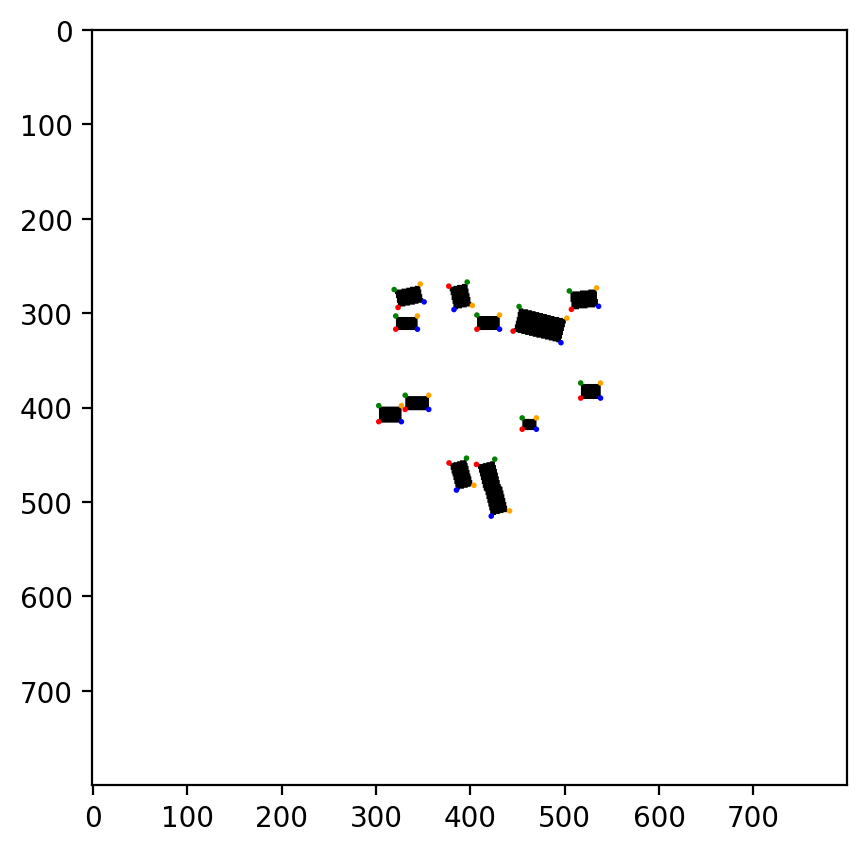

In [34]:
fig, ax = plt.subplots()
ax.imshow(test_tensors[0], cmap='binary');
for coords in test_boxes[0]:
    plt.scatter((coords[0] * 10) + 400, -(coords[1] * 10) + 400, color=['red', 'green', 'blue', 'orange'], s=1)